--- 분석 시작: D:\open_eeg_pp\openneuro_ds004315\eeg-000000.tar ---

[분석 결과]
총 발견된 세그먼트 수: 4465개
총 발견된 피험자 수: 0명
------------------------------
피험자별 세그먼트 개수:

--- 데이터 로딩 테스트 (상위 30개 세그먼트) ---
Load Success: eeg_sub-002_task-PST_eeg_seg0000
Load Success: eeg_sub-002_task-PST_eeg_seg0001
Load Success: eeg_sub-002_task-PST_eeg_seg0002
Load Success: eeg_sub-002_task-PST_eeg_seg0003
Load Success: eeg_sub-002_task-PST_eeg_seg0004
Load Success: eeg_sub-002_task-PST_eeg_seg0005
Load Success: eeg_sub-002_task-PST_eeg_seg0006
Load Success: eeg_sub-002_task-PST_eeg_seg0007
Load Success: eeg_sub-002_task-PST_eeg_seg0008
Load Success: eeg_sub-002_task-PST_eeg_seg0009
Load Success: eeg_sub-002_task-PST_eeg_seg0010
Load Success: eeg_sub-002_task-PST_eeg_seg0011
Load Success: eeg_sub-002_task-PST_eeg_seg0012
Load Success: eeg_sub-002_task-PST_eeg_seg0013
Load Success: eeg_sub-002_task-PST_eeg_seg0014
Load Success: eeg_sub-002_task-PST_eeg_seg0015
Load Success: eeg_sub-002_task-PST_eeg_seg0016
Load Success:

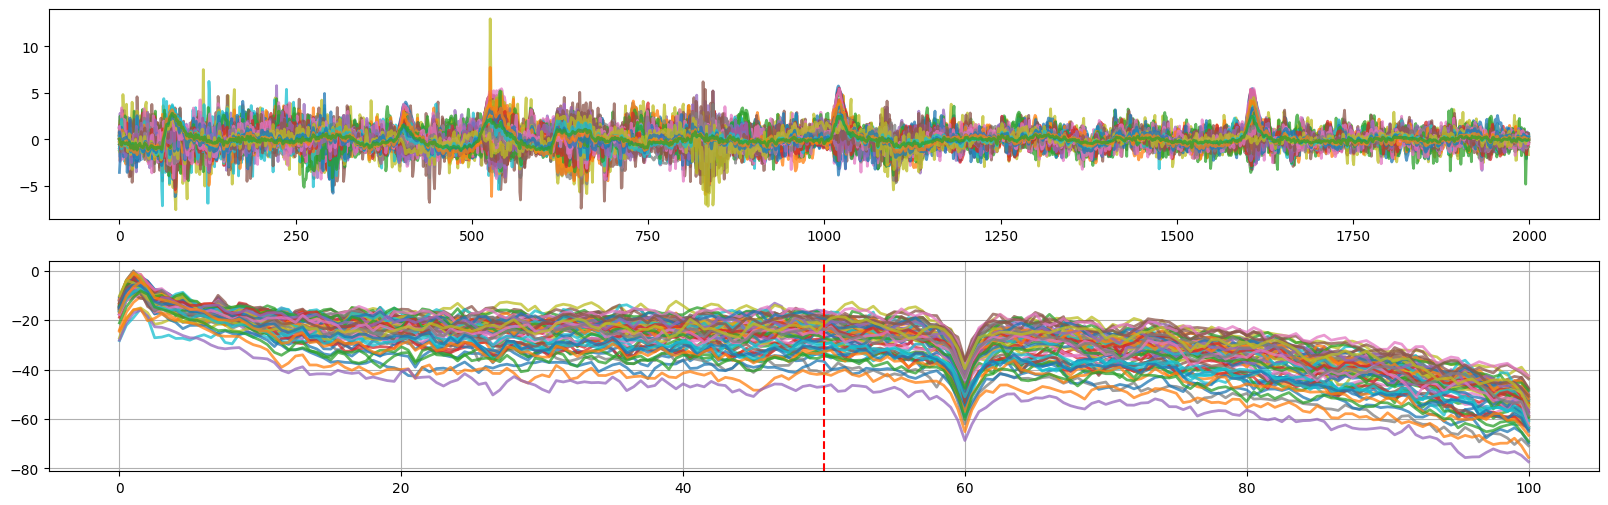

In [115]:
from scipy import signal
import tarfile
import re
import json
import numpy as np
import io
from collections import defaultdict

# ==========================================
# 2. 통계 확인 (피험자 수, 세그먼트 수)
# ==========================================
def analyze_tar_stats(path):
    print(f"--- 분석 시작: {path} ---")
    
    subject_counts = defaultdict(int)
    total_segments = 0
    
    try:
        with tarfile.open(path, "r") as tar:
            # 모든 파일 목록을 가져옵니다.
            members = tar.getmembers()
            
            for member in members:
                # 중복 카운트를 막기 위해 .info.json 파일만 기준으로 셉니다.
                if member.name.endswith(".info.json"):
                    total_segments += 1
                    
                    # 파일명에서 피험자 번호 추출 (예: ..._S005_...)
                    # 정규표현식: S 뒤에 숫자 1~3자리를 찾음
                    match = re.search(r"_S(\d{1,3})_", member.name)
                    if match:
                        subj_id = match.group(1) # '005'
                        subject_counts[subj_id] += 1
            
            print(f"\n[분석 결과]")
            print(f"총 발견된 세그먼트 수: {total_segments}개")
            print(f"총 발견된 피험자 수: {len(subject_counts)}명")
            print("-" * 30)
            print("피험자별 세그먼트 개수:")
            
            # 피험자 번호 순서대로 정렬해서 출력
            for subj in sorted(subject_counts.keys()):
                print(f"Subject {subj}: {subject_counts[subj]} segments")
                
            return members  # 데이터 로딩을 위해 멤버 리스트 반환

    except Exception as e:
        print(f"오류 발생: {e}")
        return []

# ==========================================
# 3. 데이터 로드 및 List 변환 함수
# ==========================================
def load_data_from_tar(path, limit=5):
    """
    tar 파일에서 실제 데이터를 읽어 리스트로 변환합니다.
    메모리 보호를 위해 limit 개수만큼만 샘플로 읽습니다.
    limit=None으로 하면 전부 읽습니다 (주의: 메모리 초과 가능성 있음)
    """
    data_list = []
    
    print(f"\n--- 데이터 로딩 테스트 (상위 {limit}개 세그먼트) ---")
    
    with tarfile.open(path, "r") as tar:
        members = tar.getmembers()
        
        # 확장자를 뗀 'Key'를 기준으로 파일들을 묶습니다.
        # 예: 'Lee...seg0002' -> [.eeg.npy, .coords.npy, .info.json]
        grouped_files = defaultdict(dict)
        
        for m in members:
            # 파일명 분리 (파일명, 확장자)
            if m.name.endswith(".eeg.npy"):
                key = m.name.replace(".eeg.npy", "")
                grouped_files[key]["eeg"] = m
            elif m.name.endswith(".coords.npy"):
                key = m.name.replace(".coords.npy", "")
                grouped_files[key]["coords"] = m
            elif m.name.endswith(".info.json"):
                key = m.name.replace(".info.json", "")
                grouped_files[key]["info"] = m

        # 묶인 파일들을 실제로 로드
        count = 0
        for key, files in grouped_files.items():
            if limit and count >= limit:
                break
                
            # 3개 파일이 다 짝이 맞는지 확인
            if "eeg" in files and "coords" in files and "info" in files:
                try:
                    # 1. EEG 데이터 로드 (.npy)
                    f_eeg = tar.extractfile(files["eeg"])
                    eeg_data = np.load(io.BytesIO(f_eeg.read())) # 메모리 버퍼로 읽기
                    
                    # 2. Coords 데이터 로드 (.npy)
                    f_coords = tar.extractfile(files["coords"])
                    coords_data = np.load(io.BytesIO(f_coords.read()))
                    
                    # 3. Info 데이터 로드 (.json)
                    f_info = tar.extractfile(files["info"])
                    info_data = json.load(f_info)
                    
                    # 리스트에 추가 (Dictionary 형태 추천)
                    sample = {
                        "key": key,
                        "eeg": eeg_data,       # numpy array
                        "coords": coords_data, # numpy array
                        "info": info_data      # dict
                    }
                    data_list.append(sample)
                    count += 1
                    print(f"Load Success: {key}")
                    
                except Exception as e:
                    print(f"Load Failed ({key}): {e}")

    return data_list

# ==========================================
# 실행부
# ==========================================
# 1. 통계 확인

# tar_path = 'D:\\open_eeg_pp\\physionet_siena\\eeg-000000.tar'  # 여기에 실제 파일명을 넣으세요
tar_path = 'D:\\open_eeg_pp\\openneuro_ds004315\\eeg-000000.tar'  # 여기에 실제 파일명을 넣으세요
# tar_path = 'D:\\open_eeg_pp\\icare\\eeg-000001.tar'  # 여기에 실제 파일명을 넣으세요
# tar_path = 'D:\\open_eeg_pp\\moabb_bnci2014_009\\eeg-000000.tar'  # 여기에 실제 파일명을 넣으세요
members = analyze_tar_stats(tar_path)

# 2. 데이터 로드 (샘플 3개만 로드해서 확인)
if members:
    loaded_samples = load_data_from_tar(tar_path, limit=30)
    
    # 로드된 데이터 구조 확인
    if loaded_samples:
        print("\n[첫 번째 샘플 데이터 확인]")
        print(f"Key: {loaded_samples[0]['key']}")
        print(f"EEG Shape: {loaded_samples[0]['eeg'].shape}")
        print(f"Coords Shape: {loaded_samples[0]['coords'].shape}")
        print(f"Info: {loaded_samples[0]['info']}")
        aa = loaded_samples[0]['coords']
        bb = loaded_samples[1]['eeg']
print(aa)
# bb = (bb - bb.mean(axis=-1, keepdims=True)) / (bb.std(axis=-1, keepdims=True) + 1e-8)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.subplot(211)
plt.plot(bb[:, 200*0:200*60].T, alpha=0.75, lw=2)
plt.subplot(212)
freqs, psd = signal.welch(bb, fs=200, nperseg=200*2, axis=-1)
psd = 10 * np.log10(psd)  # dB 단위로 변환
# psd = 10*np.log10(np.mean(psd, axis=0))
plt.plot(freqs, psd.T, alpha=0.75, lw=2)
plt.axvline(x=50, color='r', linestyle='--')
plt.grid()
print()

In [101]:
a = [i for i in range(20)]
a[5:-5]

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [53]:
import tarfile

with tarfile.open(tar_path, "r") as tar:
    members = tar.getmembers()
    for member in members:
        print(member.name)

Cho2017_S003_0_0_seg0000.coords.npy
Cho2017_S003_0_0_seg0000.eeg.npy
Cho2017_S003_0_0_seg0000.info.json
Cho2017_S003_0_0_seg0001.coords.npy
Cho2017_S003_0_0_seg0001.eeg.npy
Cho2017_S003_0_0_seg0001.info.json
Cho2017_S003_0_0_seg0002.coords.npy
Cho2017_S003_0_0_seg0002.eeg.npy
Cho2017_S003_0_0_seg0002.info.json
Cho2017_S003_0_0_seg0003.coords.npy
Cho2017_S003_0_0_seg0003.eeg.npy
Cho2017_S003_0_0_seg0003.info.json
Cho2017_S003_0_0_seg0004.coords.npy
Cho2017_S003_0_0_seg0004.eeg.npy
Cho2017_S003_0_0_seg0004.info.json
Cho2017_S003_0_0_seg0005.coords.npy
Cho2017_S003_0_0_seg0005.eeg.npy
Cho2017_S003_0_0_seg0005.info.json
Cho2017_S003_0_0_seg0006.coords.npy
Cho2017_S003_0_0_seg0006.eeg.npy
Cho2017_S003_0_0_seg0006.info.json
Cho2017_S003_0_0_seg0007.coords.npy
Cho2017_S003_0_0_seg0007.eeg.npy
Cho2017_S003_0_0_seg0007.info.json
Cho2017_S003_0_0_seg0008.coords.npy
Cho2017_S003_0_0_seg0008.eeg.npy
Cho2017_S003_0_0_seg0008.info.json
Cho2017_S003_0_0_seg0009.coords.npy
Cho2017_S003_0_0_seg0009.eeg

In [54]:
import moabb.datasets
from moabb.datasets import Cho2017

# 데이터 로드
dataset = Cho2017()
subject_id = 1
sessions = dataset.get_data(subjects=[subject_id])

# 로드된 구조 확인
print(f"--- Subject {subject_id} Structure ---")
total_duration = 0
for session_name, runs in sessions[subject_id].items():
    print(f"Session: {session_name}")
    for run_name, raw in runs.items():
        dur = raw.times[-1]
        total_duration += dur
        print(f"  - Run: {run_name}, Duration: {dur:.2f} sec, Samples: {len(raw)}")

print(f"\nTotal Loaded Duration: {total_duration:.2f} sec")
print(f"Total Expected Duration: {894208/512:.2f} sec") # 512Hz 가정
print(f"Missing Duration: {(894208/512) - total_duration:.2f} sec")

Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present


--- Subject 1 Structure ---
Session: 0
  - Run: 0, Duration: 1400.97 sec, Samples: 717300

Total Loaded Duration: 1400.97 sec
Total Expected Duration: 1746.50 sec
Missing Duration: 345.53 sec
